## II. BIRMINGHAM B28 HOUSING PRICE ANALYSIS

Price, Features and Location Analysis of B28 Properties in Birmingham.


### **TABLE OF CONTENTS:**

[1. Problem Statement, Data Source, its limitation and  problems encountered when using the data](#1.-Problem-Statement,-Data-Source,-its-limitation-and-problems-encountered-when-using-the-data)

[2. Data Processing](#2.-Data-Preprocessing)

[3. Visualisations to Summary the data](#3.-Visualisations-to-summary-the-data)

[4. Summary tables of the descriptive statistics the sample.](#4.-Summary-tables-of-the-descriptive-statistics-the-sample.)

[5. The 95% or 99% confidence interval of the average house price per house type](#5.-The-95-or-99-percent-confidence-interval-of-the-average-house-price-per-house-type)

[6. Analysis on Average Price in the B28 local area comparing to the average price in Birmingham city](#6.-Analysis-on-Average-Price-in-the-B28-local-area-comparing-to-the-average-price-in-Birmingham-city)

[7. Correlation Analysis Between Price and Other Property Characteristics](#7-correlation-analysis-between-price-and-other-property-characteristics)

[8. Regression Analysis and the Most Parsimonious Model](#8-regression-analysis-and-the-most-parsimonious-model)

[9. Residual Analysis for the Final (Most Parsimonious) Model](#9-residual-analysis-for-the-final-most-parsimonious-model)

[10. The Derived Statistical Model and Examples of Its Usage](#10-the-derived-statistical-model-and-examples-of-its-usage)


### 1. Problem Statement, Data Source, its limitation and  problems encountered when using the data

#### The Business Problems:

A pilot study on behalf of a market research company on behalf of an estate agency with the aim of carrying out a study on the housing market. The manager of the real estate agency wants to obtain a general view of the housing market focusing on the housing prices, type and size of properties for sale not for rent. The marketing research company wishes to determine:

1. How the local market is similar or different from the wider market.

2. Which are the most important variables in determining the price of a property .

3.  Statistical model it can use to estimate the market value of a property in the area knowing its type (Detached, Semi-detached, Flat, etc.), and factors to do with its size (number of bedrooms, bathrooms etc).facilities (Garage, garden etc) and location (distance from school, station etc)

#### Challenges when scrapping the Data:

1. The searched results page of rightmove.co.uk only shows `Address`, `Property Type`, `Number of bedrooms and bathrooms` and `Agent`. While detailed information such as `Tenure`, `Parking`, `Garden`, `Distance to nearest Station and School` can only be found on the each property's page. Making scrapping the whole population data challenging as I would had accecss every of 700+ page.
   
2. The `rightmove.co.uk` website is redered dynamically by `JavaScript`, making it impossible to scrappe by Beautifulsoup as its HTML is generated dinamically. Selenium had to be used instead, which, along with individually accessing every page - increased the scrapping time significantly. If this is applied to the larger set of 100,000+ properties (reseacrching in a country scale - perhaps), optimisation in terms of computational power and programming should be considered.

#### Challenges when iterpreting the Data:

1. The `Address` field was entered manually, then they're inconsistent (e.g. missing postcodes), having acronym (st, dr, etc.) typos. Making it difficult for geopy to decod e the location and coordinates.

2. Some properties contain missing or incorrect feilds (`Property Type`, `Number of bedrooms and bathrooms`), can only be corrected manually by intepreting the property's photos or floor plan.

3. The location of the properties are returned by `geopy` APIs, Google Maps API can be considered as an alternative to output more precise location of the properties. 

4. New properties usually doesn't contain Council Tax Band, that's why they were excluded from the Linear Regression Model as there were only a few of them and they added to much noises to the Model. However, if there're more of them AND there are more features (appliance, furnised, ect.) to improve the model predicting power, the model also can estimate the price of new houses.

#### Proposed Questions to the Stake Holders:

- What characteristics define the "wider market"? Is it regional, national, or another scope?

- Should the analysis consider additional socioeconomic or demographic factors like income levels, employment rates, or population density?

- Should the analysis consider other factors (e.g. amenities, furnised types, etc) or including third-party data to improve the analysis outcome?
  
- Should the analysis exclude certain properties (e.g., under construction, new house or special-use properties)?

#### Import the Dataset and Packages:

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from matplotlib.ticker import FuncFormatter


In [2]:
# Import the main Dataset
df = pd.read_csv('[120Sample]B28_properties_details.csv')
df_test = pd.read_csv('[Test]B28_30_Properties.csv')

# Drop excessive column due to indexing option of exporting .csv file on previous steps
df.drop('Unnamed: 0', axis = 1, inplace = True)
df_test.drop('Unnamed: 0', axis = 1, inplace = True)

In [3]:
# Dataset info:
df.head()

,address,price,type,no_bed,no_bath,agent,url,garden,parking,new_home,postcode,location,latitude,longitude,tenure,to_nearest_station,to_nearest_school,tax_band
0,"Chamberlain Crescent, Shirley, Solihull, B90 2DG",320000,Semi-Detached,3,1,"Arden Estates, Solihull",https://www.rightmove.co.uk/properties/1544876...,True,True,False,B90 2DG,"Chamberlain Crescent, Shirley, Solihull, West ...",52.407107,-1.834241,Freehold,0.5 miles,0.1 miles,Band: C
1,"Dolphin Lane, Birmingham",260000,End of Terrace,3,1,"Manny Klarico, Hall Green",https://www.rightmove.co.uk/properties/1525417...,True,True,False,NaN,"Dolphin Lane, Acocks Green, Fox Hollies, Birmi...",52.438319,-1.827190,Ask agent,0.7 miles,0.1 miles,Band: A
2,"Barrington Road, Olton, Solihull",280000,Semi-Detached,3,1,"Melvyn Danes, Solihull",https://www.rightmove.co.uk/properties/1525876...,True,True,False,NaN,"Barrington Road, Olton, Solihull, West Midland...",52.440330,-1.801880,Freehold,0.2 miles,0.2 miles,Band: C
3,"St. Bernards Road, Olton, Solihull",850000,Detached,5,3,"Andrew Grant, Covering the West Midlands",https://www.rightmove.co.uk/properties/1544543...,True,True,False,NaN,"St Bernards Road, Kineton Green, Solihull, Wes...",52.424862,-1.811723,Freehold,0.1 miles,0.2 miles,NaN
4,"Fircroft, Solihull",550000,Detached,4,2,"Ruxton Independent Estate Agents & Valuers, So...",https://www.rightmove.co.uk/properties/1498761...,True,True,False,NaN,"Fircroft, Ulverley Green, Solihull, West Midla...",52.425536,-1.797471,Freehold,0.8 miles,0.2 miles,Band: F


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address             120 non-null    object 
 1   price               120 non-null    int64  
 2   type                120 non-null    object 
 3   no_bed              120 non-null    int64  
 4   no_bath             120 non-null    int64  
 5   agent               120 non-null    object 
 6   url                 120 non-null    object 
 7   garden              120 non-null    bool   
 8   parking             120 non-null    bool   
 9   new_home            120 non-null    bool   
 10  postcode            51 non-null     object 
 11  location            120 non-null    object 
 12  latitude            120 non-null    float64
 13  longitude           120 non-null    float64
 14  tenure              120 non-null    object 
 15  to_nearest_station  120 non-null    object 
 16  to_neare

In [5]:
df.describe()

,price,no_bed,no_bath,latitude,longitude
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,352657.500000,3.116667,1.450000,52.014146,-1.839572
std,167940.641481,0.980339,0.786974,4.567517,0.024620
min,100000.000000,1.000000,1.000000,2.396880,-1.888506
25%,233750.000000,3.000000,1.000000,52.418472,-1.857149
50%,327500.000000,3.000000,1.000000,52.432450,-1.840264
75%,418750.000000,4.000000,2.000000,52.442571,-1.818434
max,1000000.000000,7.000000,7.000000,52.544624,-1.789048


### 2. Data Preprocessing

In [6]:
# Dropping 'miles' in the 2 columns: to_nearest_station and to_nearest_school and covert to float on both datasets

# Main dataset
df['to_nearest_station'] = df['to_nearest_station'].str.strip(' miles').astype(float)
df['to_nearest_school'] = df['to_nearest_school'].str.strip(' miles').astype(float)
df['tax_band'] = df['tax_band'].str.replace('Band: ', '')

# Separate Dataset for Testing the Model
df_test['to_nearest_station'] = df_test['to_nearest_station'].str.strip(' miles').astype(float)
df_test['to_nearest_school'] = df_test['to_nearest_school'].str.strip(' miles').astype(float)
df_test['tax_band'] = df_test['tax_band'].str.replace('Band: ', '')

In [7]:
# Get the postcode from the column location
postcode_pattern = r'\b(B\d{1,2}(?: \d\w{2})?)\b'
df['update_postcode'] = df['location'].str.extract(postcode_pattern)

# Update missing postcodes
df['postcode'] = df['postcode'].fillna(df['update_postcode'])
df.drop(columns = 'update_postcode', inplace = True)
df['type'].value_counts()

type
Semi-Detached             41
Terraced                  24
Detached                  23
End of Terrace             8
Apartment                  7
Flat                       6
House                      3
Maisonette                 2
Semi-Detached Bungalow     2
Bungalow                   1
Ground Flat                1
Cottage                    1
Duplex                     1
Name: count, dtype: int64

In [8]:
# Some addtional modifications to the dataframe
df[df['type'] == 'House']

# Update 3 'House' to correct type
df.loc[[23, 34], 'type'] = 'Terraced'
df.loc[42, 'type'] = 'Semi-Detached'

#Group 'Apartment' and 'Flat' and 'Ground Flat':
df['type'] = df['type'].replace('Apartment', 'Flat')
df['type'] = df['type'].replace('Ground Flat', 'Flat')

# Group 'Bungalow' and 'Semi-Detached Bungalow' as 'Bungalow'
df['type'] = df['type'].replace('Semi-Detached Bungalow', 'Bungalow')

# Replace 'Ask agent' in 'tenure' by NaNs
df['tenure'] = df['tenure'].replace('Ask agent', np.nan)

# Correct the types of the Test Dataset
df_test['type'].value_counts()
df_test['type'] = df_test['type'].replace('Apartment', 'Flat')
df_test['type'] = df_test['type'].replace('End of Terrace', 'Terraced')
df_test['type'] = df_test['type'].replace('Link Detached House', 'Detached')

# Create the new column with 4 price ranges: <200k, 200-400k, 400-600k, 600-800k, 800-1000k
bins = [0, 200000, 400000, 600000, 800000, float('inf')]
labels = ['0-200', '200-400', '400-600', '600-800', '800-1000']
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)

# Define the ordered categories
price_range_order = CategoricalDtype(categories=['0-200', '200-400', '400-600', '600-800', '800-1000'])

# Cast the column to the ordinal type
df['price_range'] = df['price_range'].astype(price_range_order)

>We can group 'End of Terrace' and 'Terrace' since they are similar and have relatively close average price, while 'Bungalow', 'Maisonette', 'Cottage', and 'Duplex' will be classified as 'Others' since there are too few observations of them to provide meaningful results or stable estimates.

In [9]:
# Convert the types
df['type'] = df['type'].replace('End of Terrace', 'Terraced')
for _ in ['Bungalow', 'Maisonette', 'Cottage', 'Duplex']:
    df['type'] = df['type'].replace(_, 'Other')

# Export the compelete dataframe for Power BI/Tableau visualisations
df.to_csv('Power_BI_data.csv')

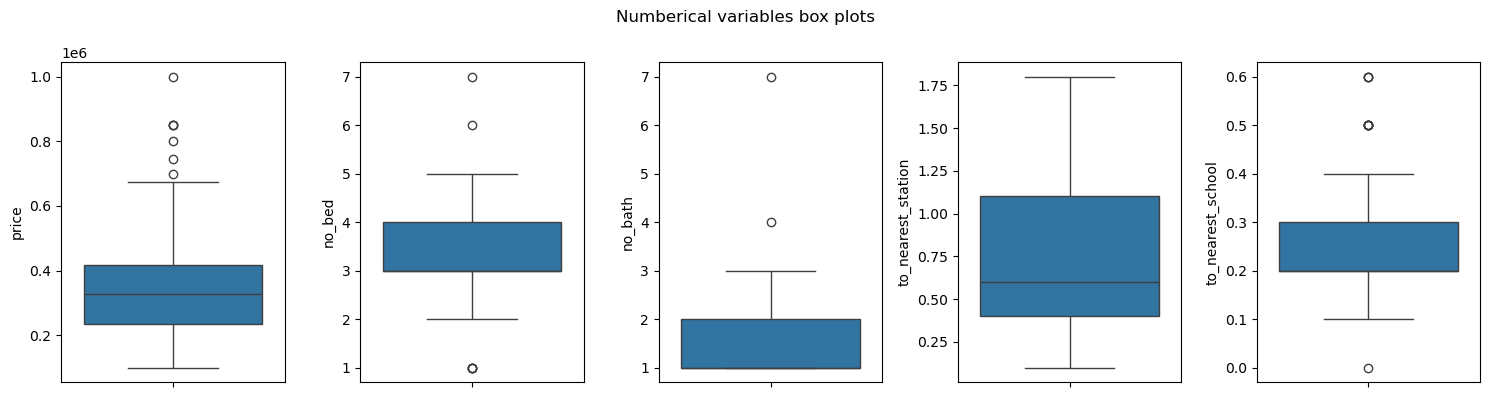

In [10]:
# Outlier Analysis
fig, axs = plt.subplots(1,5, figsize = (15,4))
fig.suptitle('Numberical variables box plots')
plt1 = sns.boxplot(df['price'], ax = axs[0])
plt2 = sns.boxplot(df['no_bed'], ax = axs[1])
plt3 = sns.boxplot(df['no_bath'], ax = axs[2])
plt1 = sns.boxplot(df['to_nearest_station'], ax = axs[3])
plt2 = sns.boxplot(df['to_nearest_school'], ax = axs[4])

plt.tight_layout()

Reasons to Keep Outliers
- Informative Data: Outliers might represent rare but important cases (e.g., luxury properties in your real estate dataset).
- Real-World Relevance: If your test data or future predictions may include similar outliers, it's important for the model to handle them.
- Statistical Validity: Arbitrarily removing data points without justification can introduce bias.

### 3. Visualisations to Summary the data:
for either the population and/or the sample (i.e. they should be of different types) to describe the data. Each visualisation should make a clear contribution to the overall narrative and a justification of the choice of visualisation in supporting that point or points. Make sure that you evaluate the visualisation methods by critiquing their adequateness and ensure that appropriate theories, principles and guidelines are followed when drawing them and are explained to the Estate Agent

#### 3.1 The Distribution of Sampled Properties' Price:

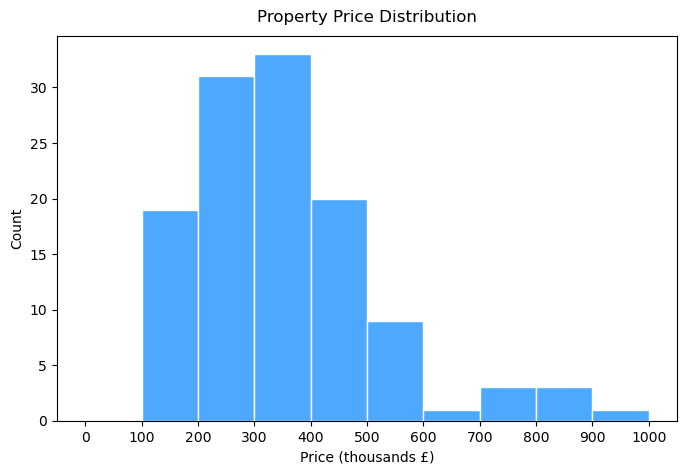

In [11]:
# Plot the histogram
bins = [x for x in range(0, 1000001, 100000)]  # Bins are from 0 to 1000 in steps of 100
plt.figure(figsize=(8, 5))  
sns.histplot(df['price'], bins = bins, edgecolor = 'white', color = '#118DFF')
plt.title("Property Price Distribution", pad=10)
plt.ylabel('Count')
plt.xlabel('Price (thousands £)')
price_ticks = bins  
plt.xticks(price_ticks, labels=[p for p in range(0, 1001, 100)])
plt.show()

#### 3.2 Heatmap of number of properties by `Type` and `Price Range`:

C:\Users\blueb\AppData\Local\Temp\ipykernel_13848\3577874685.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['type', 'price_range']).size().unstack(fill_value=0)


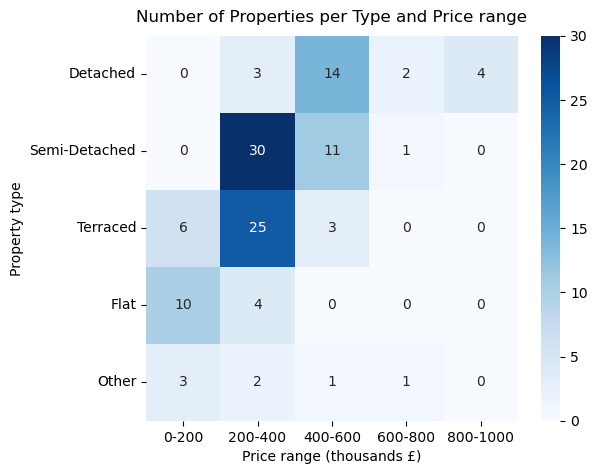

In [12]:
# Count occurrences for each combination
heatmap_data = df.groupby(['type', 'price_range']).size().unstack(fill_value=0)

# Plot the heatmap
# Reorder the rows (y-axis) by a custom order
custom_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']  # Specify the desired order for Category1
heatmap_data = heatmap_data.reindex(custom_order)

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title('Number of Properties per Type and Price range', pad=10)
plt.ylabel('Property type')
plt.xlabel('Price range (thousands £)')
plt.show()

#### 3.3	Stacked Bar Number of Properties by `Types` and `Price Range`:

C:\Users\blueb\AppData\Local\Temp\ipykernel_13848\2769557335.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['price_range', 'type']).size().reset_index(name='count')


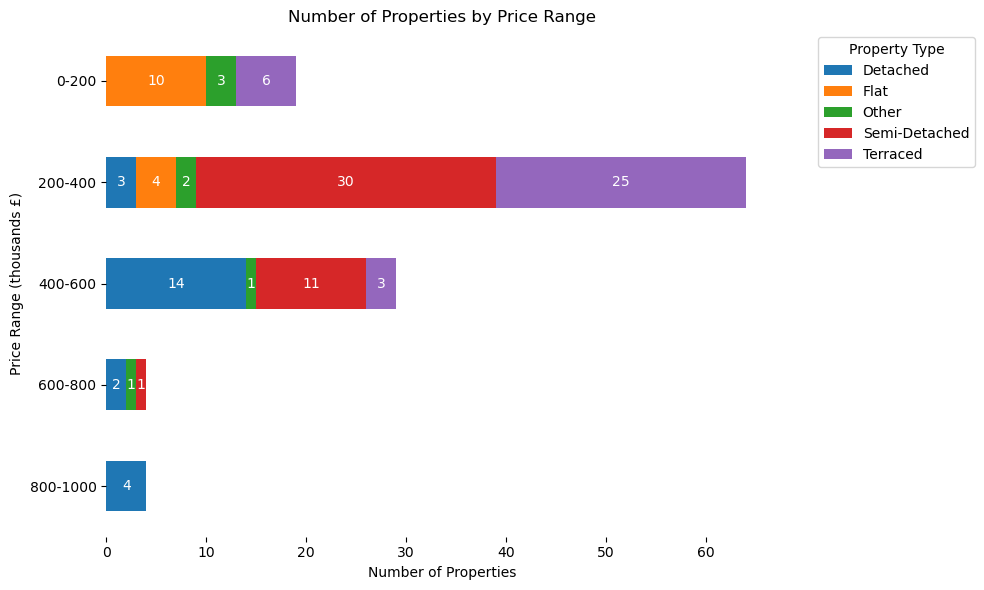

In [13]:
# Preprocessing to create a pivot table for stacked bar plot
count_df = df.groupby(['price_range', 'type']).size().reset_index(name='count')
pivot_df = count_df.pivot(index='price_range', columns='type', values='count').fillna(0)

# Ensuring the order of price ranges
pivot_df = pivot_df.reindex(['800-1000', '600-800', '400-600', '200-400', '0-200'])

# Plotting the stacked bar plot
ax = pivot_df.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6)
)

# Add numbers to the plot
for i, price_range in enumerate(pivot_df.index):
    cumulative_width = 0
    for col in pivot_df.columns:
        value = pivot_df.loc[price_range, col]
        if value > 0:
            # Annotate the bar
            ax.text(
                cumulative_width + value / 2,  # Position: middle of the segment
                i,  # Position: y-coordinate (row index)
                str(int(value)),  # Convert to int for clean display
                va='center',  # Center vertically
                ha='center',  # Center horizontally
                fontsize=10,
                color='white'  # Text color
            )
            cumulative_width += value

# Titles and labels
plt.title('Number of Properties by Price Range')
plt.xlabel('Number of Properties')
plt.ylabel('Price Range (thousands £)')
plt.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove the border by hiding the spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

#### 3.4 Average price per `Type` and `Number of Bedrooms`:

C:\Users\blueb\AppData\Local\Temp\ipykernel_13848\14781538.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['no_bed', 'price_range']).size().unstack(fill_value=0)


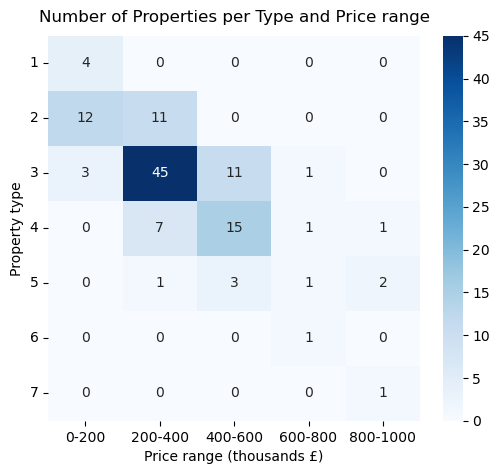

In [14]:
# Count occurrences for each combination
heatmap_data = df.groupby(['no_bed', 'price_range']).size().unstack(fill_value=0)

# Plot the heatmap
# Reorder the rows (y-axis) by a custom order
# custom_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']  # Specify the desired order for Category1
# heatmap_data = heatmap_data.reindex(custom_order)

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title('Number of Properties per Type and Price range', pad=10)
plt.ylabel('Property type')
plt.xlabel('Price range (thousands £)')
plt.show()

#### 3.5 Number of Propeties by their `Types` and each type's `Average Price`

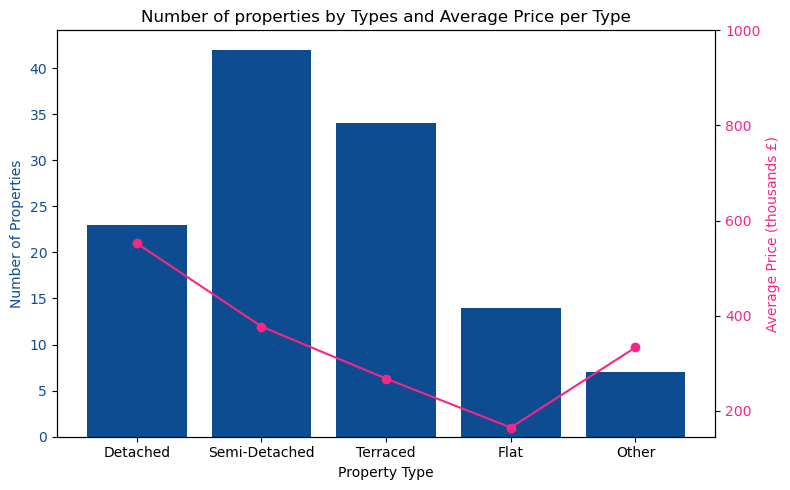

In [15]:
# Calculate the number of properties and average price by type
property_counts = df['type'].value_counts().sort_index()
average_prices = df.groupby('type')['price'].mean().sort_index()

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Specified order
desired_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']

# Reindex property_counts and average_prices to match the desired order
property_counts = property_counts.reindex(desired_order)
average_prices = average_prices.reindex(desired_order)

# Bar plot for the number of properties by type
ax1.bar(property_counts.index, property_counts.values, color='#0E4C92', label='Number of Properties')
ax1.set_xlabel('Property Type')
ax1.set_ylabel('Number of Properties', color='#0E4C92')
ax1.tick_params(axis='y', labelcolor='#0E4C92')

# Line plot for the average price by type (using a second y-axis)
ax2 = ax1.twinx()
ax2.plot(average_prices.index, average_prices.values, color='#F72585', marker='o', label='Average Price')
ax2.set_ylabel('Average Price (thousands £)', color='#F72585')
ax2.tick_params(axis='y', labelcolor='#F72585')
price_ticks = [200000, 400000, 600000, 800000, 1000000]  
plt.yticks(price_ticks, labels=[200, 400, 600, 800, 1000])

# Add titles and show plot
plt.title('Number of properties by Types and Average Price per Type')
fig.tight_layout()
plt.show()

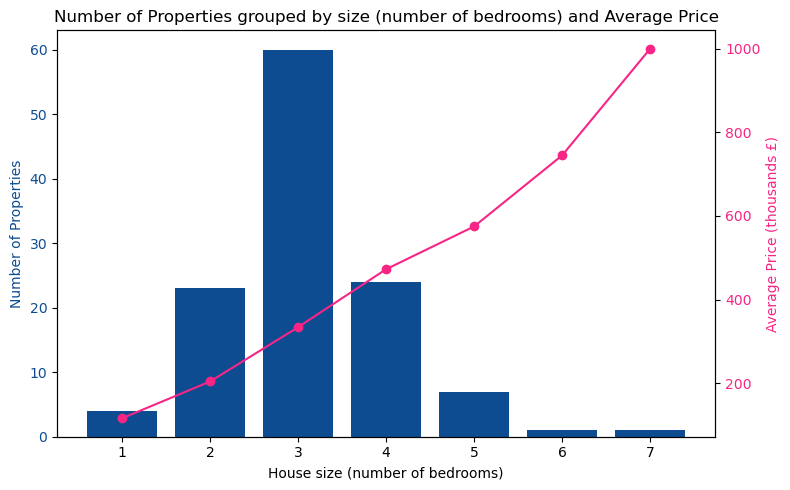

In [16]:
# Calculate the number of properties and average price by their size (no of bedrooms)
property_counts = df['no_bed'].value_counts().sort_index()
average_prices = df.groupby('no_bed')['price'].mean().sort_index()

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for the number of properties by type
ax1.bar(property_counts.index, property_counts.values, color='#0E4C92', label='Number of Properties')
ax1.set_xlabel('House size (number of bedrooms)')
ax1.set_ylabel('Number of Properties', color='#0E4C92')
ax1.tick_params(axis='y', labelcolor='#0E4C92')

# Line plot for the average price by type (using a second y-axis)
ax2 = ax1.twinx()
ax2.plot(average_prices.index, average_prices.values, color='#F72585', marker='o', label='Average Price')
ax2.set_ylabel('Average Price (thousands £)', color='#F72585')
ax2.tick_params(axis='y', labelcolor='#F72585')
price_ticks = [200000, 400000, 600000, 800000, 1000000]  
plt.yticks(price_ticks, labels=[200, 400, 600, 800, 1000])

# Add titles and show plot
plt.title('Number of Properties grouped by size (number of bedrooms) and Average Price')
fig.tight_layout()
plt.show()

### 4. Summary tables of the descriptive statistics the sample. 

#### 4.1 Numerical values Desriptive Statistics Table

In [17]:
#Summary table
df_summary = df.drop(columns=['latitude', 'longitude'])
df_summary.describe(include='all')

,address,price,type,no_bed,no_bath,agent,url,garden,parking,new_home,postcode,location,tenure,to_nearest_station,to_nearest_school,tax_band,price_range
count,120,120.000000,120,120.000000,120.000000,120,120,120,120,120,120,120,116,120.000000,120.000000,110,120
unique,115,NaN,5,NaN,NaN,46,120,2,2,2,79,109,2,NaN,NaN,8,5
top,"Stratford Road, Shirley, Solihull",NaN,Semi-Detached,NaN,NaN,"Shipways, Shirley",https://www.rightmove.co.uk/properties/1544876...,True,True,False,B13,"Yardley Wood Road, Springfield, Wake Green, Bi...",Freehold,NaN,NaN,C,200-400
freq,2,NaN,42,NaN,NaN,12,1,108,107,116,8,2,99,NaN,NaN,29,64
mean,NaN,352657.500000,NaN,3.116667,1.450000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.705833,0.234167,NaN,NaN
std,NaN,167940.641481,NaN,0.980339,0.786974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.417334,0.121956,NaN,NaN
min,NaN,100000.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100000,0.000000,NaN,NaN
25%,NaN,233750.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,0.200000,NaN,NaN
50%,NaN,327500.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,0.200000,NaN,NaN
75%,NaN,418750.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.100000,0.300000,NaN,NaN


#### 4.2. Descriptive Statistics of Price by Prorperty Type

In [18]:
# Descriptive Statistics by Property Types
pd.options.display.width = 200 # Adjust display width
price_stats_by_type = df.groupby('type')['price'].describe()

print(price_stats_by_type)

               count           mean            std       min       25%       50%       75%        max
type                                                                                                 
Detached        23.0  552391.304348  184019.944356  300000.0  425000.0  500000.0  625000.0  1000000.0
Flat            14.0  165285.714286   39139.157201  100000.0  129625.0  177500.0  197500.0   215000.0
Other            7.0  333557.142857  235602.925895  135000.0  187475.0  200000.0  412500.0   799950.0
Semi-Detached   42.0  377500.000000   95261.194208  250000.0  325000.0  352500.0  400000.0   745000.0
Terraced        34.0  267941.176471   78760.450457  120000.0  221250.0  255000.0  290000.0   465000.0


C:\Users\blueb\AppData\Local\Temp\ipykernel_13848\1647655034.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='price', data=df, palette='Set2')


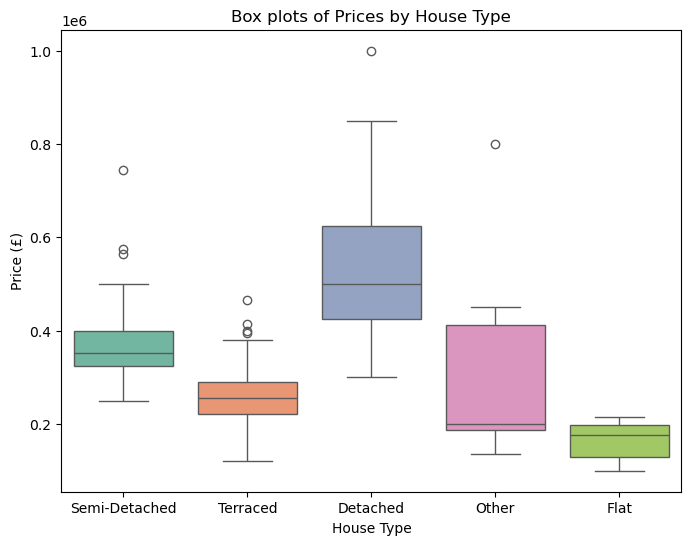

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='price', data=df, palette='Set2')
plt.title('Box plots of Prices by House Type')
plt.ylabel('Price (£)')
plt.xlabel('House Type')
plt.show()

#### 4.3. Descriptive Statistics of Price by Bedroom number

In [20]:
# Descriptive Statistics by Bedroom number
price_stats_by_no_bed = df.groupby('no_bed')['price'].describe().T
print(price_stats_by_no_bed)

no_bed             1              2              3              4              5         6          7
count        4.00000      23.000000      60.000000      24.000000       7.000000       1.0        1.0
mean    116125.00000  204106.521739  334082.500000  472708.333333  575000.000000  745000.0  1000000.0
std      13603.76786   56899.988625  104806.358499  122802.237328  213150.963717       NaN        NaN
min     100000.00000  120000.000000  180000.000000  300000.000000  365000.000000  745000.0  1000000.0
25%     107500.00000  175000.000000  263750.000000  391250.000000  407500.000000  745000.0  1000000.0
50%     117500.00000  199950.000000  325000.000000  447500.000000  470000.000000  745000.0  1000000.0
75%     126125.00000  212500.000000  375000.000000  527500.000000  762500.000000  745000.0  1000000.0
max     129500.00000  375000.000000  799950.000000  850000.000000  850000.000000  745000.0  1000000.0


C:\Users\blueb\AppData\Local\Temp\ipykernel_13848\2179419883.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='no_bed', y='price', data=df, palette='Set2')


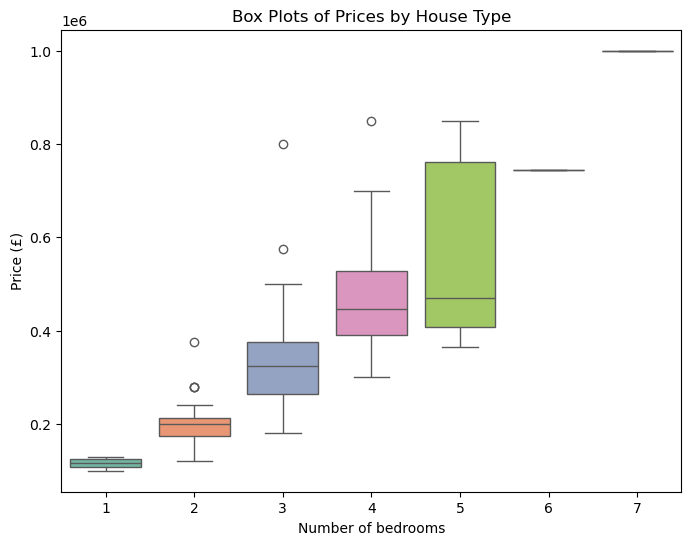

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='no_bed', y='price', data=df, palette='Set2')
plt.title('Box Plots of Prices by House Type')
plt.ylabel('Price (£)')
plt.xlabel('Number of bedrooms')
plt.show()

### 5. The 95 or 99 percent confidence interval of the average house price per house type
Assuming that the housing prices are normally distributed:


**Confidence Interval**

To test the reliability of the sample, we will estimate the actual average price with 95% confidence level. 

The degree of accuracy (z-value) which reflect the confidence level will be 1.96. 

The statistical table provide information about the sample mean, standard deviation and the sample size.  While CI is given by: 

$$
\bar{x} - z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}} \leq \mu \leq \bar{x} + z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}
$$


Therefore, there is 95% chance that the average second-hand car price selected will lie between £16,916.04 and £18,075.73 and there are 2.5% probability to collect the price larger than £18,075.73 or smaller than £16,916.04


In [22]:
# average price of each types
df_type_price = df.groupby('type')['price'].mean()
df_type_price

type
Detached         552391.304348
Flat             165285.714286
Other            333557.142857
Semi-Detached    377500.000000
Terraced         267941.176471
Name: price, dtype: float64

In [23]:
# std dev price of each types
df_type_price = df.groupby('type')['price'].std()
df_type_price

type
Detached         184019.944356
Flat              39139.157201
Other            235602.925895
Semi-Detached     95261.194208
Terraced          78760.450457
Name: price, dtype: float64

In [24]:
# 95% CI of sample Price:

sample_prices = df['price']

# Calculate the sample mean and standard error
mean_price = np.mean(sample_prices)
std_dev = np.std(sample_prices)
std_error = np.std(sample_prices, ddof=1) / np.sqrt(len(sample_prices))

# For a 95% confidence interval, use the z-score for a normal distribution
z_score = stats.norm.ppf(0.975)  # For 95% CI, we use 0.975 for two-tailed CI

# Calculate the margin of error
margin_of_error = z_score * std_error

# Calculate the confidence interval
lower_bound = mean_price - margin_of_error
upper_bound = mean_price + margin_of_error

print(" - 95% CI of sample Price:")
print(f"  MoE: {margin_of_error}")
print(f"  Mean Price: {mean_price:.2f}, Standard Deviation: {std_dev:.2f} ")
print(f"  95% CI: [{lower_bound:.2f}; {upper_bound:.2f}]")
print("\n")

 - 95% CI of sample Price:
  MoE: 30047.84122292398
  Mean Price: 352657.50, Standard Deviation: 167239.42 
  95% CI: [322609.66; 382705.34]




#### 5.1 CI of `Semi-Detached`, and `Terraced` Prices

In [25]:
# z-stats: CI of Semi-Detached, and Terraced

for property_type in ['Semi-Detached', 'Terraced']:
    prices = df[df['type'] == property_type]['price'].dropna()

    # Calculate the sample mean and standard error
    mean_price = np.mean(prices)
    std_dev = np.std(prices)
    std_error = np.std(prices, ddof=1) / np.sqrt(len(prices))

    # For a 95% confidence interval, use the z-score for a normal distribution
    z_score = stats.norm.ppf(0.975)  # For 95% CI, we use 0.975 for two-tailed CI

    # Calculate the margin of error
    margin_of_error = z_score * std_error

    # Calculate the confidence interval
    lower_bound = mean_price - margin_of_error
    upper_bound = mean_price + margin_of_error

    print(f"- {property_type}:")
    print(f"  Mean Price: {mean_price:.2f}, Standard Deviation: {std_dev:.2f} ")
    print(f"  MoE: {margin_of_error}")
    print(f"  95% CI: [{lower_bound:.2f}; {upper_bound:.2f}]")
    print("\n")

- Semi-Detached:
  Mean Price: 377500.00, Standard Deviation: 94120.30 
  MoE: 28809.748524269588
  95% CI: [348690.25; 406309.75]


- Terraced:
  Mean Price: 267941.18, Standard Deviation: 77593.56 
  MoE: 26473.832932465186
  95% CI: [241467.34; 294415.01]




#### 5.2 CI of `Detached`, `Flat` and `Other` Prices

In [26]:
for property_type in ['Detached', 'Flat', 'Other']:
    prices = df[df['type'] == property_type]['price'].dropna()

    n = len(prices)  # Sample size
    mean = np.mean(prices)  # Sample mean
    sem = np.std(prices, ddof=1) / np.sqrt(n)  # Standard error of the mean (using ddof=1 for sample std)

    # Step 2: Determine the t-value for 95% confidence level
    confidence = 0.95
    alpha = 1 - confidence
    t_value = stats.t.ppf(1 - alpha / 2, df=n-1)  # Two-tailed t-value

    # Step 3: Compute margin of error
    margin_of_error = t_value * sem

    # Step 4: Construct the confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error


    print(f"- {property_type}:")
    print(f'  t = {t_value}')
    print(f"  MOE: {margin_of_error:.2f}")
    print(f"  Mean Price: {mean:.2f}, Standard Deviation: {std_dev:.2f} ")
    print(f"  MoE: {margin_of_error}")
    print(f"  95% CI: ({lower_bound:.2f}, {upper_bound:.2f})")

- Detached:
  t = 2.0738730679040147
  MOE: 79576.19
  Mean Price: 552391.30, Standard Deviation: 77593.56 
  MoE: 79576.19126170018
  95% CI: (472815.11, 631967.50)
- Flat:
  t = 2.1603686564610127
  MOE: 22598.28
  Mean Price: 165285.71, Standard Deviation: 77593.56 
  MoE: 22598.276569996044
  95% CI: (142687.44, 187883.99)
- Other:
  t = 2.4469118511449692
  MOE: 217896.36
  Mean Price: 333557.14, Standard Deviation: 77593.56 
  MoE: 217896.36430565675
  95% CI: (115660.78, 551453.51)


In [27]:
# type order:
type_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']
df_type_price = df_type_price[type_order]

In [28]:
means_type= [552391.30, 377500.00, 267941.18, 165285.71, 333557.14]
lower_bounds_type = [472815.11, 348690.25, 241467.34, 142687.44, 115660.78]
upper_bounds_type = [631967.50, 406309.75, 294415.01, 187883.99, 551453.51]

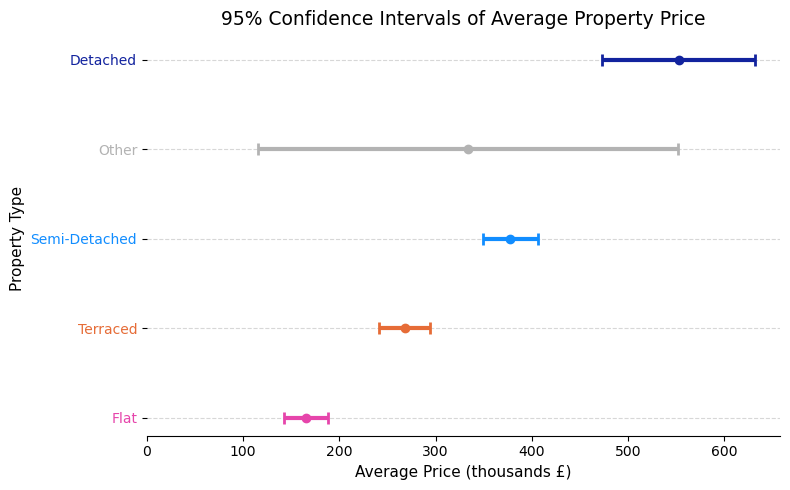

In [29]:
import itertools
# Plotting
# Calculate asymmetric errors
yerr_lower = np.array([means_type[i] - lower_bounds_type[i] for i in range(len(means_type))])
yerr_upper = np.array([upper_bounds_type[i] - means_type[i] for i in range(len(means_type))])

# Define custom order for property types
custom_order = ['Detached', 'Other', 'Semi-Detached' ,'Terraced', 'Flat']
custom_order = custom_order[::-1]

# x axis price ticks
price_ticks = [x for x in range(0, 600001, 100000)]  # Bins are from 0 to 1000 in steps of 100

# Rearrange the data according to the custom order
type_order_custom = custom_order
means_type_custom = [means_type[type_order.index(property_type)] for property_type in custom_order]
yerr_lower_custom = [yerr_lower[type_order.index(property_type)] for property_type in custom_order]
yerr_upper_custom = [yerr_upper[type_order.index(property_type)] for property_type in custom_order]

# Use a colormap to generate colors
colors = itertools.cycle(['#E645AB', '#E66C37', '#118DFF', '#B3B3B3', '#12239E'])

# Plotting with custom order
plt.figure(figsize=(8, 5))
for i in range(len(type_order)):
    plt.errorbar(means_type_custom[i], type_order_custom[i], 
                 xerr=[[yerr_lower_custom[i]], [yerr_upper_custom[i]]], 
                capsize=4, capthick=2, label=f'{type_order[i]}', color=next(colors), 
                linewidth=3, fmt = 'o')
    
    # Apply custom colors to y-tick labels
ax = plt.gca()  # Get current axes
for label, color in zip(ax.get_yticklabels(), colors):
    label.set_color(color)
    
# Add labels and title
plt.title('95% Confidence Intervals of Average Property Price', fontsize = 13.5, pad = 12)
plt.ylabel('Property Type', fontsize = 11)
plt.xlabel('Average Price (thousands £)', fontsize = 11)

# Hide only the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Hide y-tick marks but keep the label and grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)



plt.xticks(price_ticks, labels=[p for p in range(0, 601, 100)], alpha = 1)
plt.tight_layout()
plt.show()
plt.show()

#### Fore reference: Bootstraping method to estimate the Confidence Interval of the Population Price:

In [30]:
sample_data = df['price']

# Set number of bootstrap samples
n_bootstrap_samples = 1000

# Container for bootstrap estimates of the mean
bootstrap_means = []

# Generate bootstrap samples and calculate the mean for each sample
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(sample_data, size=len(sample_data), replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))

bootstrap_means = np.array(bootstrap_means)

# Estimate of the population mean
bootstrap_mean_estimate = np.mean(bootstrap_means)
# Confidence interval (e.g., 95%)
conf_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"Estimated Population Mean: {bootstrap_mean_estimate}")
print(f"95% Confidence Interval: {conf_interval}")

Estimated Population Mean: 352782.03625
95% Confidence Interval: [323056.98958333 382402.82291667]


### 6. Analysis on Average Price in the B28 local area comparing to the average price in Birmingham city

Average Price of a Property by type, and its type sample:

In [31]:
print("B28 AREA:")
print (f'- Average Price of 120 sampled Properties: {df['price'].mean()}')
for pr_type in df['type'].unique():
    print(f'- Number of {pr_type}: {len(df[df['type'] == pr_type])},  Average Price: {df[df['type'] == pr_type]['price'].mean()}')

B28 AREA:
- Average Price of 120 sampled Properties: 352657.5
- Number of Semi-Detached: 42,  Average Price: 377500.0
- Number of Terraced: 34,  Average Price: 267941.17647058825
- Number of Detached: 23,  Average Price: 552391.304347826
- Number of Other: 7,  Average Price: 333557.14285714284
- Number of Flat: 14,  Average Price: 165285.7142857143


For Hypothesis testing, `Semi-Detached` and `Terraced` can use Z-test while `Detached` and `Flat` use t-test (sample size < 30)

1. The provisional average house price in Birmingham in August 2024 was `£234,000.`

2. For each property type, average prices as of August 2024 in Birmingham were (https://www.ons.gov.uk/visualisations/housingpriceslocal/E08000025/):

- Detached properties: `£434,000`
- Semi-detached properties: `£268,000`
- Terraced properties: `£215,000`
- Flats and maisonettes: `£159,000`


#### 1. z-test on the Overall Average Price

Z-Test for Average Property Type:
- Null Hypothesis: Mean(B28) = Mean(Birmingham)
- Alternative Hypothesis: Mean(B28) != Mean(Birmingham)

In [32]:
# 1. Calculate the sample mean and sample size
sample_data = df['price']
sample_mean = np.mean(sample_data)
n = len(sample_data)

# 2. Calculate the population standard deviation (or use sample standard deviation if population SD is unknown)
# If population standard deviation is known, replace 'sample_std' with that value
sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation (use ddof=1 for sample)

# 3. Hypothesized population mean
mu_0 = 234000

# 4. Calculate the z-statistic
z_stat = (sample_mean - mu_0) / (sample_std / np.sqrt(n))

# 5. Calculate the p-value for a right-tailed test (since we are testing if the mean is greater)
p_value = 1 - stats.norm.cdf(z_stat)

# 6. Decide based on significance level (e.g., alpha = 0.05)
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha)

# Output the results
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis: The mean is significantly greater than 234,000.")
else:
    print("Fail to reject the null hypothesis: The mean is not significantly greater than 234,000.")

Z-statistic: 7.739804825583754
P-value: 4.9960036108132044e-15
Reject the null hypothesis: The mean is significantly greater than 234,000.


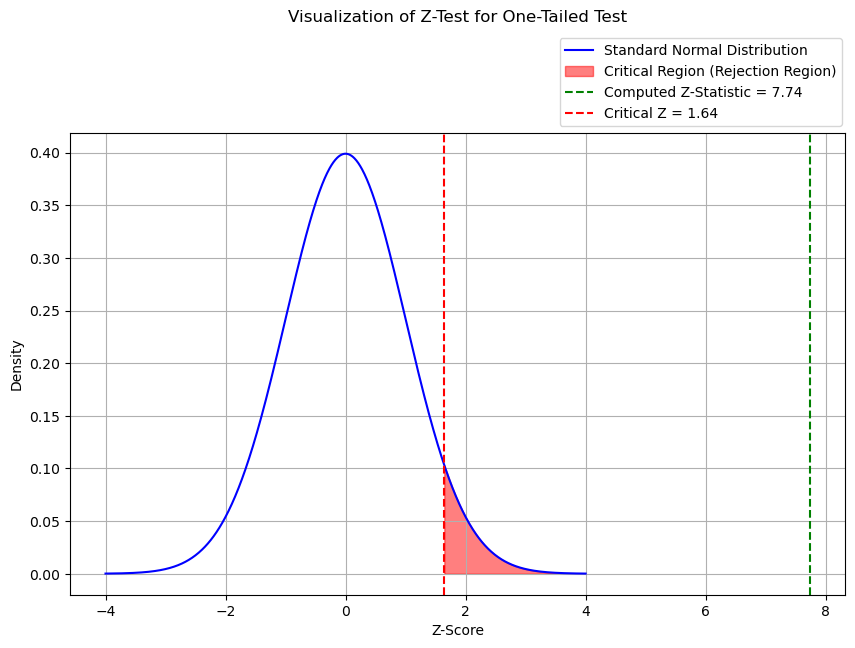

In [33]:
# Set up the x values for the z-distribution (range of z-scores)
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Standard Normal Distribution", color="blue")

# Fill the area to the right of the critical z-value
plt.fill_between(x, y, where=(x >= z_critical), color="red", alpha=0.5, label="Critical Region (Rejection Region)")

# Plot the computed z-statistic
plt.axvline(x=z_stat, color='green', linestyle='--', label=f"Computed Z-Statistic = {z_stat:.2f}")

# Mark the critical value
plt.axvline(x=z_critical, color='red', linestyle='--', label=f"Critical Z = {z_critical:.2f}")

# Labels and title
plt.title("Visualization of Z-Test for One-Tailed Test", pad = 80)
plt.xlabel("Z-Score")
plt.ylabel("Density")
plt.legend(loc='upper right', bbox_to_anchor=(1.005, 1.22))

# Show plot
plt.grid(True)
plt.show()


#### 2. z-test on `Semi-Detached` and `Terraced`

In [34]:
population_means_per_type = {
    'Detached': 434000,
    'Semi-Detached': 268000,
    'Terraced': 215000,
    'Flat': 159000
}

for type in ['Semi-Detached', 'Terraced']:
    sample_data = df[df['type'] == type]['price']
    
    # 1. Calculate the sample mean and sample size
    sample_mean = np.mean(sample_data)
    n = len(sample_data)

    # 2. Calculate the population standard deviation (or use sample standard deviation if population SD is unknown)
    # If population standard deviation is known, replace 'sample_std' with that value
    sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation (use ddof=1 for sample)

    # 3. Hypothesized population mean
    mu_0 = population_means_per_type[type]

    # 4. Calculate the z-statistic
    z_stat = (sample_mean - mu_0) / (sample_std / np.sqrt(n))

    # 5. Calculate the p-value for a right-tailed test (since we are testing if the mean is greater)
    p_value = 1 - stats.norm.cdf(z_stat)

    # 6. Decide based on significance level (e.g., alpha = 0.05)
    alpha = 0.05
    z_critical = stats.norm.ppf(1 - alpha)

    # Output the results
    print(f'- Property type: {type}')
    print(f"  Z-statistic: {z_stat}")
    print(f"  P-value: {p_value}")

    if p_value < alpha:
        print(f"  Reject the null hypothesis: The mean is significantly greater than {mu_0}.")
    else:
        print(f"  Fail to reject the null hypothesis: The mean is not significantly greater than {mu_0}.")
        
    print('-' * 80)


- Property type: Semi-Detached
  Z-statistic: 7.4494248405653885
  P-value: 4.6851411639181606e-14
  Reject the null hypothesis: The mean is significantly greater than 268000.
--------------------------------------------------------------------------------
- Property type: Terraced
  Z-statistic: 3.919447533201236
  P-value: 4.437608934437787e-05
  Reject the null hypothesis: The mean is significantly greater than 215000.
--------------------------------------------------------------------------------


#### 3. t-test on `Detached` and `Flat`

In [35]:
for type in ['Detached', 'Flat']:
    sample_data = df[df['type'] == type]['price']
    # Calculate sample statistics
    sample_mean = np.mean(sample_data)
    population_mean =  population_means_per_type[type] # Hypothesized mean
    sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation
    n = len(sample_data)
    degrees_of_freedom = n - 1

    # Calculate t-statistic
    t_stat = (sample_mean - population_mean) / (sample_std / np.sqrt(n))

    # Find the critical t-value for a one-tailed test at alpha = 0.05
    alpha = 0.05
    critical_t_value = stats.t.ppf(1 - alpha, df=degrees_of_freedom)  # One-tailed
    
     # Calculate the one-tailed p-value
    p_value = 1 - stats.t.cdf(t_stat, df=degrees_of_freedom)

    # Print results
    print(f'- Property type: {type}')
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value (one-tailed): {p_value:.4f}")
    print(f"  Critical t-value (one-tailed, alpha=0.05): {critical_t_value:.4f}")

    # Decision
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print(f"  Reject the null hypothesis: The mean property price is significantly greater than {population_means_per_type[type]}.")
    else:
        print(f"  Fail to reject the null hypothesis: There is not enough evidence to conclude the mean property price is greater than {population_means_per_type[type]}.")

- Property type: Detached
  t-statistic: 3.0855
  p-value (one-tailed): 0.0027
  Critical t-value (one-tailed, alpha=0.05): 1.7171
  Reject the null hypothesis: The mean property price is significantly greater than 434000.
- Property type: Flat
  t-statistic: 0.6009
  p-value (one-tailed): 0.2791
  Critical t-value (one-tailed, alpha=0.05): 1.7709
  Fail to reject the null hypothesis: There is not enough evidence to conclude the mean property price is greater than 159000.


### 7. Correlation analysis between price and other property characteristics

In [36]:
# the data frame with variables used for correlation matrix
df_cor = df[['price', 'type', 'no_bed', 'no_bath', 'garden', 'parking','new_home','tenure','to_nearest_station','to_nearest_school', 'tax_band']]

In [37]:
#drop the rows with NaNs in 'tenure'
df_cor.dropna(inplace=True)

# Drop rows where tax_band is 'TBC'
df_cor = df_cor[df_cor['tax_band'] != 'TBC']
df_cor = df_cor.reset_index(drop = True)

C:\Users\blueb\AppData\Local\Temp\ipykernel_13848\2171767488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor.dropna(inplace=True)


In [38]:
# Mapping of tax bands to numeric values
tax_band_mapping = {
    'A'     : 1,
    'B'     : 2,
    'C'     : 3,
    'D'     : 4,
    'E'     : 5,
    'F'     : 6,
    'G'     : 7,
    'H'     : 8,
}
# Apply the mapping
df_cor['tax_band_encoded'] = df_cor['tax_band'].map(tax_band_mapping)
df_cor.drop(columns='tax_band', inplace=True)

# Create the encoder
encoder_corr = OneHotEncoder(sparse_output=False)  # Set drop='first' to drop the first category as baselines
encoded_data_corr = encoder_corr.fit_transform(df_cor[['type', 'tenure']])
encoded_df_corr = pd.DataFrame(encoded_data_corr, columns=encoder_corr.get_feature_names_out(['type', 'tenure']))
df_corr = pd.concat([df_cor.drop(columns=['type', 'tenure']), encoded_df_corr], axis=1)

#dropping 'new_home' as there're no new_home in the cleaned dataframe
df_corr.drop(columns='new_home', inplace=True)

print(df_corr)

     price  no_bed  no_bath  garden  parking  to_nearest_station  to_nearest_school  tax_band_encoded  type_Detached  type_Flat  type_Other  type_Semi-Detached  type_Terraced  tenure_Freehold  \
0   320000       3        1    True     True                 0.5                0.1                 3            0.0        0.0         0.0                 1.0            0.0              1.0   
1   280000       3        1    True     True                 0.2                0.2                 3            0.0        0.0         0.0                 1.0            0.0              1.0   
2   550000       4        2    True     True                 0.8                0.2                 6            1.0        0.0         0.0                 0.0            0.0              1.0   
3   700000       4        2    True     True                 1.2                0.2                 6            1.0        0.0         0.0                 0.0            0.0              1.0   
4   395000       4       

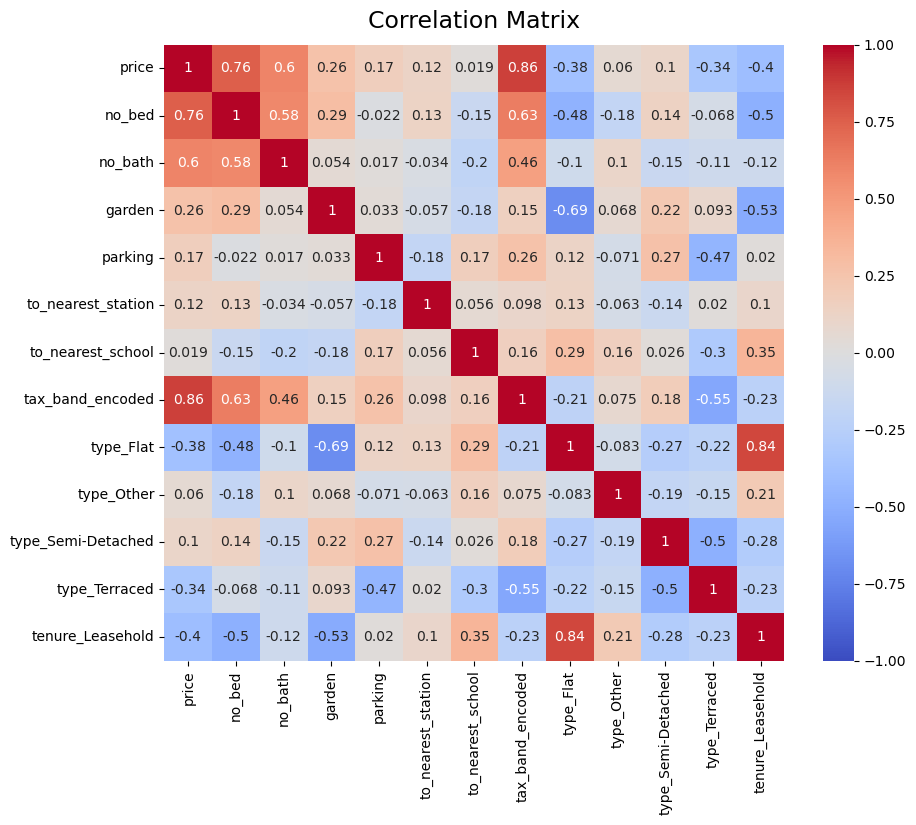

In [39]:
# Calculate the correlation matrix
corr_matrix = df_corr.drop(columns=['type_Detached', 'tenure_Freehold']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize = 17, pad = 12)
plt.show()

#### Scatter plots of Predictors vs. Prices

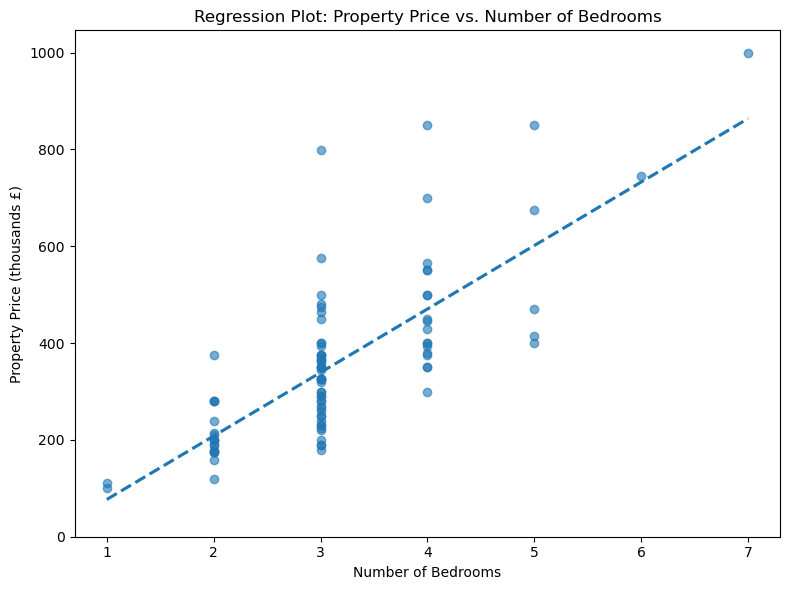

In [40]:
# Regression plotss
price_tick_reg = [p for p in range(0, 1000001, 200000)]

plt.figure(figsize=(8, 6))
sns.regplot(x='no_bed', y='price', data=df_corr,
            scatter_kws={'alpha': 0.6},   # Customize scatter points
            line_kws={'linestyle': '--'},  # Dashed regression line
            ci=None)  # Remove confidence interval)
plt.title('Regression Plot: Property Price vs. Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Property Price (thousands £)')
plt.yticks(price_tick_reg, labels=[p for p in range(0, 1001, 200)])
plt.tight_layout()
plt.show()

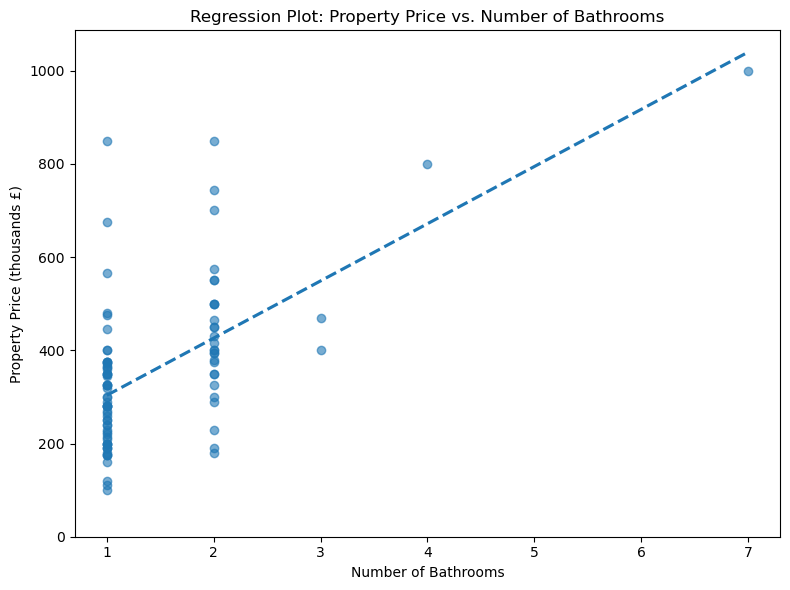

In [41]:
# Regression plotss
price_tick_reg = [p for p in range(0, 1000001, 200000)]

plt.figure(figsize=(8, 6))
sns.regplot(x='no_bath', y='price', data=df_corr,
            scatter_kws={'alpha': 0.6},   # Customize scatter points
            line_kws={'linestyle': '--'},  # Dashed regression line
            ci=None)  # Remove confidence interval)
plt.title('Regression Plot: Property Price vs. Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Property Price (thousands £)')
plt.yticks(price_tick_reg, labels=[p for p in range(0, 1001, 200)])
plt.tight_layout()
plt.show()

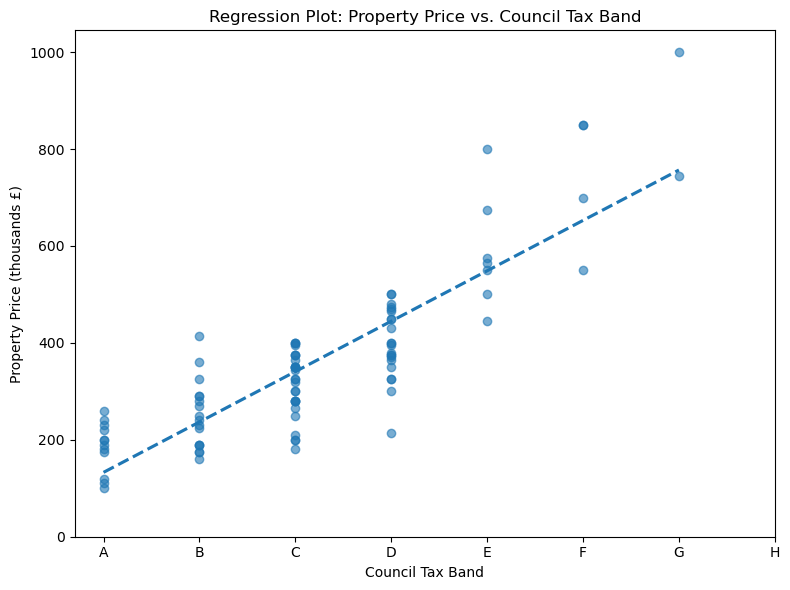

In [42]:
# Regression plotss
price_tick_reg = [p for p in range(0, 1000001, 200000)]
price_tick_tax = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

plt.figure(figsize=(8, 6))
sns.regplot(x='tax_band_encoded', y='price', data=df_corr,
            scatter_kws={'alpha': 0.6},   # Customize scatter points
            line_kws={'linestyle': '--'},  # Dashed regression line
            ci=None)  # Remove confidence interval)
plt.title('Regression Plot: Property Price vs. Council Tax Band')
plt.xlabel('Council Tax Band')
plt.ylabel('Property Price (thousands £)')
plt.yticks(price_tick_reg, labels=[p for p in range(0, 1001, 200)])
plt.xticks([p for p in range(1, 9, 1)] ,price_tick_tax)
plt.tight_layout()
plt.show()

In [43]:
# Calculate correlations
spearman_corr, _ = stats.spearmanr(df_corr['price'], df_corr['tax_band_encoded'])
pearson_corr, _ = stats.pearsonr(df_corr['price'], df_corr['tax_band_encoded'])
kendall_corr, _ = stats.kendalltau(df_corr['price'], df_corr['tax_band_encoded'])

print("Spearman's Correlation:", spearman_corr)
print("Pearson's Correlation:", pearson_corr)
print("Kendall's Tau Correlation:", kendall_corr)

Spearman's Correlation: 0.832981731805082
Pearson's Correlation: 0.8617456807455822
Kendall's Tau Correlation: 0.7097918605227405


In [44]:
# Calculate VIF for each feature

# Remove the dependent variable (Price)
X_vif = df_corr.drop(columns=['price', 'type_Detached', 'tenure_Freehold']).astype(float)

# Add a constant for intercept
X_vif = sm.add_constant(X_vif)

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif['Feature'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

               Feature        VIF
0                const  88.943251
1               no_bed   3.860427
2              no_bath   2.254971
3               garden   2.060531
4              parking   1.488249
5   to_nearest_station   1.220013
6    to_nearest_school   1.420853
7     tax_band_encoded   3.831388
8            type_Flat   7.889736
9           type_Other   1.974503
10  type_Semi-Detached   2.618956
11       type_Terraced   4.418090
12    tenure_Leasehold   5.302584


**Observations**:
- `Number of bedrooms` (`no_bed`), and `Council Tax Band` (`tax_band_encoded`) have strong possitive correlation (`0.76` and `0.86`) with `price` (0.7 ≤ r < 1)
- `Number of bathrooms` (`no_bath`), whether or not a property is `Detached` (`type_Detached`), and whether a property's tenure is `Freehold` (`tenure_Freehold`) depict Moderate Possitive Correlation with `price` (0.3 ≤ r < 0.7)
- Conversely, whether or not a property is a `Flat` or `Terraced` moderately negatively correlated with the `price` (-0.7 < r ≤ -0.3)
- Suprisingly, whether a property have a `garden`, `parking`, and its distance to the nearest station doesn't seem to affect the `price`. This might due to the large proportions of properties in this area have these feature and have the distance <0.5 miles to the closest stations (sample a wider area might be the solution). Furthermore, there're almost no correlation between distance to the closest school.



>Note: This corrlation analysis on the Sample excludes properties with missing `Council Tax Band` and `Tenure`

### 8. Regression analysis and the most parsimonious model

#### Encode the variables

In [45]:
# the data frame with variables used for linear regression
df_lg = df[['price', 'type', 'no_bed', 'no_bath', 'garden', 'parking','new_home','tenure','to_nearest_station','to_nearest_school', 'tax_band']]

# Calculate IQR within each property type
Q1 = df_lg.groupby('no_bed')['price'].transform('quantile', 0.25)
Q3 = df_lg.groupby('no_bed')['price'].transform('quantile', 0.75)
IQR = Q3 - Q1

# Define stricter bounds for far outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out far outliers
df_lg = df_lg[(df_lg['price'] >= lower_bound) & (df_lg['price'] <= upper_bound)]


# Calculate IQR within each property type
Q1_bath = df_lg.groupby('no_bath')['price'].transform('quantile', 0.25)
Q3_bath = df_lg.groupby('no_bath')['price'].transform('quantile', 0.75)
IQR_bath = Q3_bath - Q1_bath

# Define stricter bounds for far outliers
lower_bound_bath = Q1_bath - 2 * IQR_bath
upper_bound_bath = Q3_bath + 2 * IQR_bath

# Filter out far outliers
df_lg = df_lg[(df_lg['price'] >= lower_bound_bath) & (df_lg['price'] <= upper_bound_bath)]

#drop the rows with NaNs in 'tenure'
df_lg.dropna(inplace=True)


# Drop rows where tax_band is 'TBC'
df_lg  = df_lg [df_lg ['tax_band'] != 'TBC']
df_lg  = df_lg.reset_index(drop = True)

# Create the encoder
encoder_reg = OneHotEncoder(drop='first', sparse_output=False)  # Set drop='first' to drop the first category as baselines
encoded_data_reg = encoder_reg.fit_transform(df_lg[['type','garden', 'parking', 'new_home', 'tenure']])
encoded_df_reg = pd.DataFrame(encoded_data_reg, columns=encoder_reg.get_feature_names_out(['type','garden', 'parking', 'new_home', 'tenure']))
df_reg = pd.concat([df_lg.drop(columns=['type','garden', 'parking', 'new_home', 'tenure']), encoded_df_reg], axis=1)

# Apply the mapping
df_reg['tax_band_encoded'] = df_reg['tax_band'].map(tax_band_mapping)
df_reg.drop(columns='tax_band', inplace=True)

#### [Training_Set] 1. Train the Initial Linear Regression Model with all variables

In [46]:
training_predictors = ['no_bed', 'no_bath', 'garden_True', 'parking_True',
                       'to_nearest_station', 'to_nearest_school',	'type_Flat', 
                       'type_Other',	'type_Semi-Detached',	'type_Terraced',
                       'tenure_Leasehold', 'tax_band_encoded']

def linear_reg(dependent, indipendent):
    ''' This function fits the Linear Regression OLS model

    Arguments:
        dependent -- dependent (predicted) variariable
        indipendent -- independent (predictor) variariables

    Returns:
        summary table of the trained model
    '''
        
    X_OLS = indipendent
    y_OLS = dependent

    # OLS model
    X_OLS = sm.add_constant(X_OLS)
    model_OLS = sm.OLS(y_OLS,X_OLS)
    results_OLS = model_OLS.fit()

    return results_OLS.summary()

linear_reg(df_reg['price'], df_reg[training_predictors])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     53.80
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           9.65e-31
Time:                        17:57:25   Log-Likelihood:                -1019.9
No. Observations:                  84   AIC:                             2066.
Df Residuals:                      71   BIC:                             2097.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.062e+04   5.03e+04     -0.608      0.545   -1.31e+05    6.98e+04
no_bed              2.914e+04    1.3e+04      2.236      0.028    3153.894    5.51e+04
no_bath             4.941e+04   1.16e+04      4.247      0.000    2.62e+04    7.26e+04
garden_True        -1425.9645    2.8e+04     -0.051      0.959   -5.72e+04    5.43e+04
parking_True        2.842e+04   2.14e+04      1.327      0.189   -1.43e+04    7.11e+04
to_nearest_station   3.73e+04   1.41e+04      2.654      0.010    9277.287    6.53e+04
to_nearest_school   4.748e+04   5.34e+04      0.889      0.377    -5.9e+04    1.54e+05
type_Flat          -6.223e+04   4.97e+04     -1.252      0.215   -1.61e+05    3.69e+04
type_Other         -8217.8988   4.27e+04     -0.192      0.848   -9.34e+04     7.7e+04
type_Semi-Detached   566.3618   1.93e+04      0.029      0.977   -3.79e+04    3.91e+04
type_Terraced      -1.243e+04   2.49e+04     -0.499      0.619   -6.21e+04    3.72e+04
tenure_Leasehold   -4.971e+04   4.17e+04     -1.192      0.237   -1.33e+05    3.35e+04
tax_band_encoded    5.288e+04   7872.322      6.717      0.000    3.72e+04    6.86e+04
==============================================================================
Omnibus:                        0.412   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.145
Skew:                           0.090   Prob(JB):                        0.930
Kurtosis:                       3.094   Cond. No.                         70.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### [Training_Set] 2. Train the Linear Regression Model with significant variables

In [47]:
#parsimonious model training predictors
pars_training_predictors = ['no_bed', 'no_bath', 'to_nearest_station', 'tax_band_encoded']

# Train the parsimounious Model
linear_reg(df_reg['price'], df_reg[pars_training_predictors])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     133.8
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           2.31e-34
Time:                        17:57:25   Log-Likelihood:                -1030.9
No. Observations:                  84   AIC:                             2072.
Df Residuals:                      79   BIC:                             2084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.998e+04   2.23e+04     -3.143      0.002   -1.14e+05   -2.57e+04
no_bed              5.748e+04   9412.672      6.107      0.000    3.87e+04    7.62e+04
no_bath             2.776e+04   9658.803      2.875      0.005    8539.109     4.7e+04
to_nearest_station  1.666e+04   1.41e+04      1.180      0.242   -1.14e+04    4.48e+04
tax_band_encoded     5.74e+04   5683.424     10.099      0.000    4.61e+04    6.87e+04
==============================================================================
Omnibus:                        1.117   Durbin-Watson:                   2.353
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.202
Skew:                           0.237   Prob(JB):                        0.548
Kurtosis:                       2.655   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Drop `to_nearest_station` and train the final model again:

In [48]:
#parsimonious model training predictors
pars_training_predictors = ['no_bed', 'no_bath', 'tax_band_encoded']

# Train the parsimounious Model
linear_reg(df_reg['price'], df_reg[pars_training_predictors])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     177.1
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           3.16e-35
Time:                        17:57:26   Log-Likelihood:                -1031.6
No. Observations:                  84   AIC:                             2071.
Df Residuals:                      80   BIC:                             2081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                -6e+04   2.06e+04     -2.906      0.005   -1.01e+05   -1.89e+04
no_bed            5.812e+04   9419.988      6.170      0.000    3.94e+04    7.69e+04
no_bath           2.691e+04   9655.240      2.787      0.007    7695.663    4.61e+04
tax_band_encoded  5.786e+04   5683.434     10.181      0.000    4.66e+04    6.92e+04
==============================================================================
Omnibus:                        1.795   Durbin-Watson:                   2.368
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.814
Skew:                           0.305   Prob(JB):                        0.404
Kurtosis:                       2.618   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Explanation of Output
- Coefficient: Shows the intercept and slope for the regression line.
- P-value: Tests if coefficients significantly differ from zero.
- R-squared: Indicates how well the independent variable explains the variation in the dependent variable.

In [49]:
pars_training_predictors_2 = ['no_bed', 'no_bath', 'tax_band_encoded']


# Using Sckiktlearn to train and later score the model instead
X = df_reg[pars_training_predictors_2]
y = df_reg['price']

#Linear Regression model
model_sckit1 = LinearRegression()
model_sckit1.fit(X, y)

# Making predictions
y_pred = model_sckit1.predict(X)

# Output results
print("1. Intercept:", model_sckit1.intercept_)
print("2. Coefficient:", model_sckit1.coef_)
print("3. Mean Squared Error:", mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("4. R^2 Score:", r2)
print("5. Adjusted R^2:", (1 - (1 - r2) * ((len(df_reg) - 1) / (len(df_reg) - 4 - 1))))


1. Intercept: -59998.3313135106
2. Coefficient: [58124.36809973 26910.20237131 57863.93085274]
3. Mean Squared Error: 2719537627.4838495
4. R^2 Score: 0.8691450894819135
5. Adjusted R^2: 0.8625195243923901


#### [Testing_Set] Using the separate 30 properties set to Score to the derived Model:

In [50]:
# Keeping only appropriate columns
df_test = df_test[['price', 'no_bed','to_nearest_station','to_nearest_school', 'type', 'no_bath', 'tenure', 'tax_band']]

#drop the 4 rows with NaNs
df_test.dropna(inplace=True)
# Drop rows where tax_band is 'TBC'
df_test = df_test[df_test['tax_band'] != 'Band: TBC']
df_test = df_test.reset_index(drop = True)

# Get dummies
# Create the encoder
encoder_test = OneHotEncoder(drop='first', sparse_output=False)  # Set drop='first' to drop the first category as baselines
encoded_data_test = encoder_test.fit_transform(df_test[['tenure', 'type']])
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoder_test.get_feature_names_out(['tenure', 'type']))


# Mapping of tax bands to numeric values
# Apply the mapping
df_test['tax_band_encoded'] = df_test['tax_band'].map(tax_band_mapping)
df_test.drop(columns='tax_band', inplace=True)

df_test = pd.concat([df_test.drop(columns=['tenure', 'type']), encoded_df_test], axis=1)

x_test = df_test.drop(columns='price')
# adding the columns accordingly to the model
x_test['type_Other'] = 0

# Correct the column order  'no_bed', 'no_bath', 'to_nearest_station', 'to_nearest_school',	'type_Flat', 'type_Other',	'type_Semi-Detached',	'type_Terraced', 'tenure_Leasehold', 'tax_band_encoded'
x_test = x_test[pars_training_predictors]


In [52]:
# Score the Separate Test Data to the trained Model
actual_price = df_test['price']
# Predictions
predict_price = model_sckit1.predict(x_test)
# Output results
print("1. Intercept:", model_sckit1.intercept_)
print("2. Coefficient:", model_sckit1.coef_)
print("3. Mean Squared Error:", mean_squared_error(actual_price, predict_price))
r2 = r2_score(actual_price, predict_price)
print("4. R^2 Score:", r2)
print("5. Adjusted R^2:", (1 - (1 - r2) * ((len(df_reg) - 1) / (len(df_reg) - 4 - 1))))

1. Intercept: -59998.3313135106
2. Coefficient: [58124.36809973 26910.20237131 57863.93085274]
3. Mean Squared Error: 2035221984.4719038
4. R^2 Score: 0.8854396495511934
5. Adjusted R^2: 0.8796391254778361


### 9. Residual analysis for the final (most parsimonious) model
There is no need to carry out the residual analysis for any other model. Comment on the suitability of the final model with regard to its adequacy, goodness of fit and suitability. If the model is inadequate, what does it mean and comment on what should be done to address this problem. (Hint: residual analysis refers to checking the five regression assumptions).

#### 1. [Training_Set] Residual Analysis:

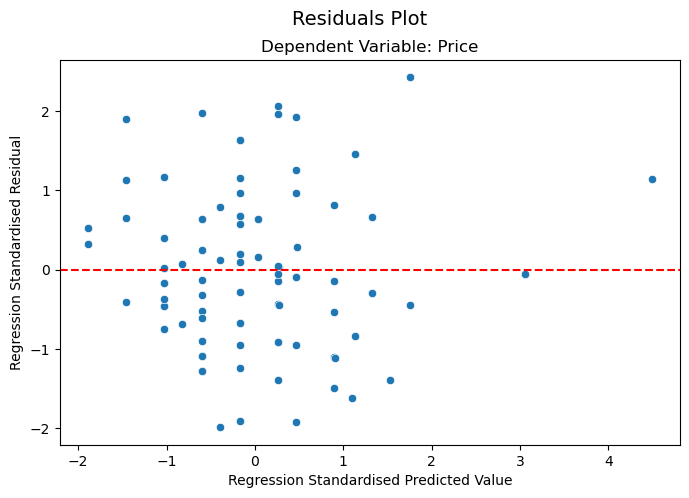

In [53]:
# Predict values and calculate residuals
residuals = y - y_pred

# Standardize the residuals
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Standardize the predicted values
standardized_predicted_values = (y_pred - np.mean(y_pred)) / np.std(y_pred)

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=standardized_predicted_values, y=standardized_residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Regression Standardised Predicted Value')
plt.ylabel('Regression Standardised Residual')
plt.suptitle('Residuals Plot', fontsize = 14)
plt.title('Dependent Variable: Price')
plt.show()

Residual Normality Testing:

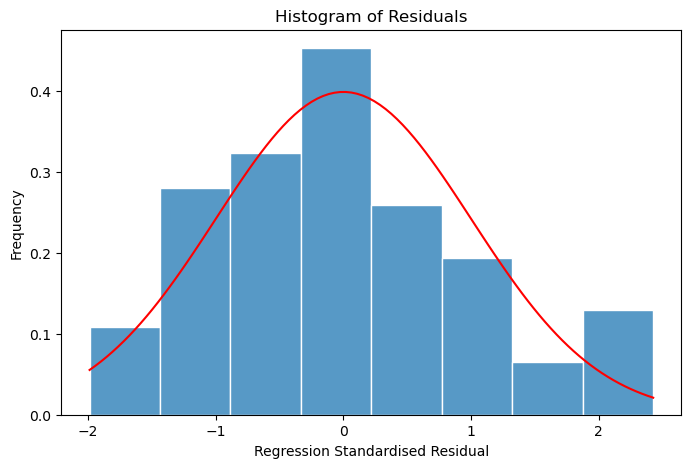

In [54]:
# Histogram of residuals
# Example Data: Replace 'df["price"]' with your actual column

# Fit a normal distribution to the data
mean_res = np.mean(standardized_residuals)
std_dev_res = np.std(standardized_residuals)

# Generate x values for the normal curve
x_res = np.linspace(min(standardized_residuals), max(standardized_residuals), 100)

# Calculate the y values for the normal distribution
y_res = stats.norm.pdf(x_res, mean_res, std_dev_res)
plt.figure(figsize=(8, 5))
sns.histplot(standardized_residuals, kde=False, stat='density', edgecolor = 'white')
# Plot the normal curve
plt.plot(x_res, y_res, color='red', label="Normal Curve")
plt.xlabel('Regression Standardised Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

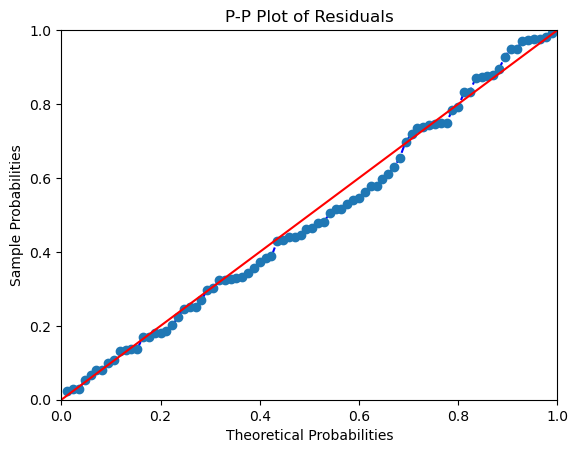

In [55]:
# Compute the standardized residuals
residuals_standardized = (residuals - np.mean(residuals)) / np.std(residuals)

# Create the P-P plot
sm.ProbPlot(residuals_standardized).ppplot(line='45', linestyle = '--')

# Add title
plt.title("P-P Plot of Residuals")
plt.show()

In [56]:
stat, p_value = stats.shapiro(residuals_standardized)
print("Shapiro-Wilk Test: p-value =", p_value)

if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are NOT normally distributed.")

Shapiro-Wilk Test: p-value = 0.308242419177854
Residuals are normally distributed.


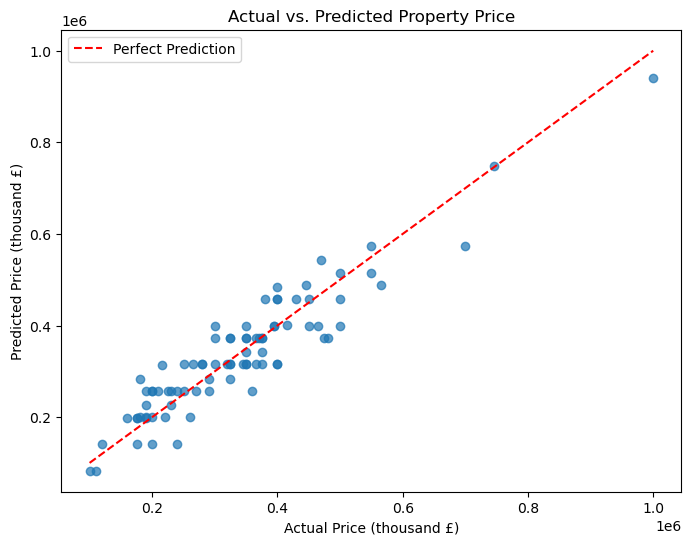

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label = 'Perfect Prediction')  # Line for perfect prediction  
plt.xlabel('Actual Price (thousand £)')
plt.ylabel('Predicted Price (thousand £)')
plt.title('Actual vs. Predicted Property Price')
plt.legend(loc='upper left')
plt.show()

#### 2. [Testing_Set] Residual Analysis

In [58]:
test_results = pd.DataFrame({
    'y_pred': np.array(predict_price),
    'y_actual': np.array(actual_price)
})
test_results['y_residuals'] = test_results['y_pred'] - test_results['y_actual']

#### Test set Residual Analysis:

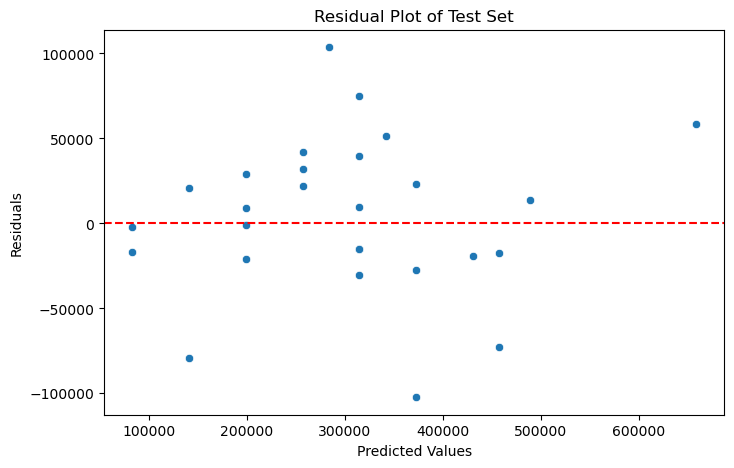

In [59]:
# Residual plot of test set
plt.figure(figsize=(8, 5))
sns.scatterplot(data=test_results, x = 'y_pred', y = 'y_residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot of Test Set')
plt.show()

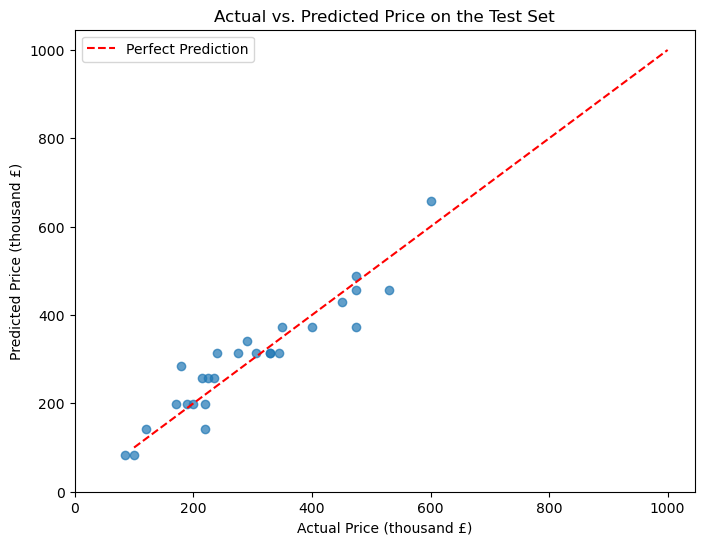

In [60]:
# Actual vs. Prediction Plot
bins = [x for x in range(0, 1000001, 200000)]  # Bins are from 0 to 1000 in steps of 100
plt.figure(figsize=(8, 6))
plt.scatter(test_results['y_actual'], test_results['y_pred'], alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label = 'Perfect Prediction')  # Line for perfect prediction
price_ticks = bins  
plt.xticks(price_ticks, labels=[p for p in range(0, 1001, 200)])
plt.yticks(price_ticks, labels=[p for p in range(0, 1001, 200)])
plt.xlabel('Actual Price (thousand £)')
plt.ylabel('Predicted Price (thousand £)')
plt.title('Actual vs. Predicted Price on the Test Set')
plt.legend(loc = 'upper left')
plt.show()


### 10. The derived statistical model and examples of its usage.

The Price of a Property in Birmingham's B28 Area can be estimated:

$$\text{Price} = 30364.027 \cdot \text{no\_bed} + 38688.433 \cdot \text{no\_bath} - 76766.099 \cdot \text{tenure\_Leasehold} + 75976.709 \cdot \text{tax\_band\_encoded} - 24610.985
$$

Where:
- `no_bed`: Number of Bedrooms of that particular property.
- `no_bath`: Number of Bathrooms.
- `tenure_Leasehold`: 1 if it's Leasehold, 0 if Freehold
- `tax_bad_encoded`: UK Council Tax Bad, 1-9 correspond to A-H bands


To test its usage, and to make sure the model wasn't overfitted: The separate test set of 30 properties from the population were scored to the model and provided the residual and accuracy in the previous section, proving the accuracy of the predicting model.